**Essa atividade e conhecida como remote procedure call (RPC), onde um cliente envia uma demanda ao servidor e o mesmo responde**


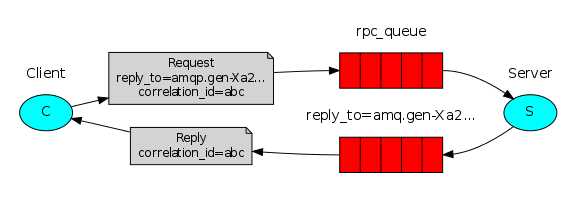



**Tecnicamente simula uma arquitetura cliente servidor, utilizando mensageria**

In [ ]:
#!/usr/bin/env python
import pika
                                              #servidor
connection = pika.BlockingConnection(
    pika.ConnectionParameters(host='localhost'))

channel = connection.channel()

channel.queue_declare(queue='rpc_queue')


def fib(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fib(n - 1) + fib(n - 2)


def on_request(ch, method, props, body):
    n = int(body)

    print(" [.] fib(%s)" % n)
    response = fib(n)

    ch.basic_publish(exchange='',
                     routing_key=props.reply_to,
                     properties=pika.BasicProperties(correlation_id = \
                                                         props.correlation_id),
                     body=str(response))
    ch.basic_ack(delivery_tag=method.delivery_tag)


channel.basic_qos(prefetch_count=1)
channel.basic_consume(queue='rpc_queue', on_message_callback=on_request)

print(" [x] Awaiting RPC requests")
channel.start_consuming()

In [ ]:
#!/usr/bin/env python
import pika
import uuid
                                            #cliente

class FibonacciRpcClient(object):

    def __init__(self):
        self.connection = pika.BlockingConnection(
            pika.ConnectionParameters(host='localhost'))

        self.channel = self.connection.channel()

        result = self.channel.queue_declare(queue='', exclusive=True)
        self.callback_queue = result.method.queue

        self.channel.basic_consume(
            queue=self.callback_queue,
            on_message_callback=self.on_response,
            auto_ack=True)

        self.response = None
        self.corr_id = None

    def on_response(self, ch, method, props, body):
        if self.corr_id == props.correlation_id:
            self.response = body

    def call(self, n):
        self.response = None
        self.corr_id = str(uuid.uuid4())
        self.channel.basic_publish(
            exchange='',
            routing_key='rpc_queue',
            properties=pika.BasicProperties(
                reply_to=self.callback_queue,
                correlation_id=self.corr_id,
            ),
            body=str(n))
        self.connection.process_data_events(time_limit=None)
        return int(self.response)


fibonacci_rpc = FibonacciRpcClient()

print(" [x] Requesting fib(30)")
response = fibonacci_rpc.call(30)
print(" [.] Got %r" % response)